In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs

# EDA

In [2]:
data = pd.read_csv(
    "../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, 
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
data['sentence_idx'] = data['sentence_idx'].apply(int)
data['tag'] = data['tag'].apply(lambda x: x if x == 'O' else x[2:])
print(data.shape)
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


Number of Sentences: 35177
Maximum sequence length: 140
Number of unique words: 30172


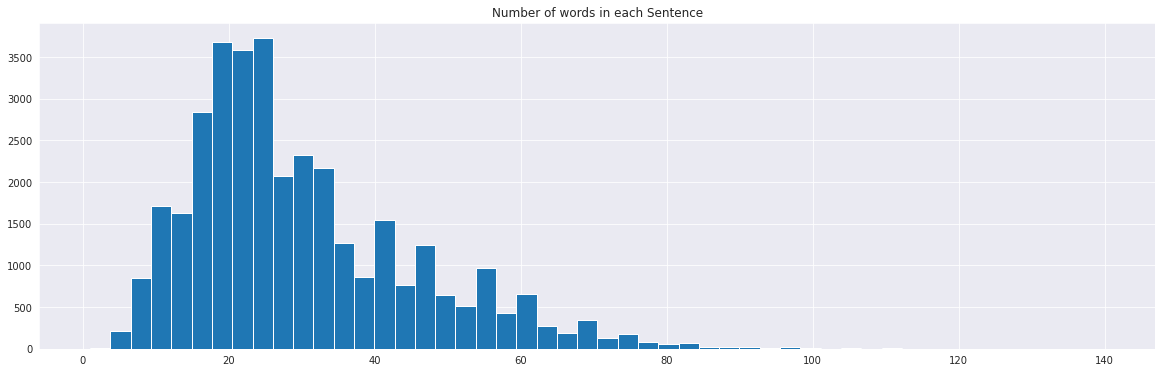

In [3]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(data['sentence_idx'].value_counts().values, bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = np.max(data['sentence_idx'].value_counts().values)
print('Number of Sentences:', data['sentence_idx'].nunique())
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 9


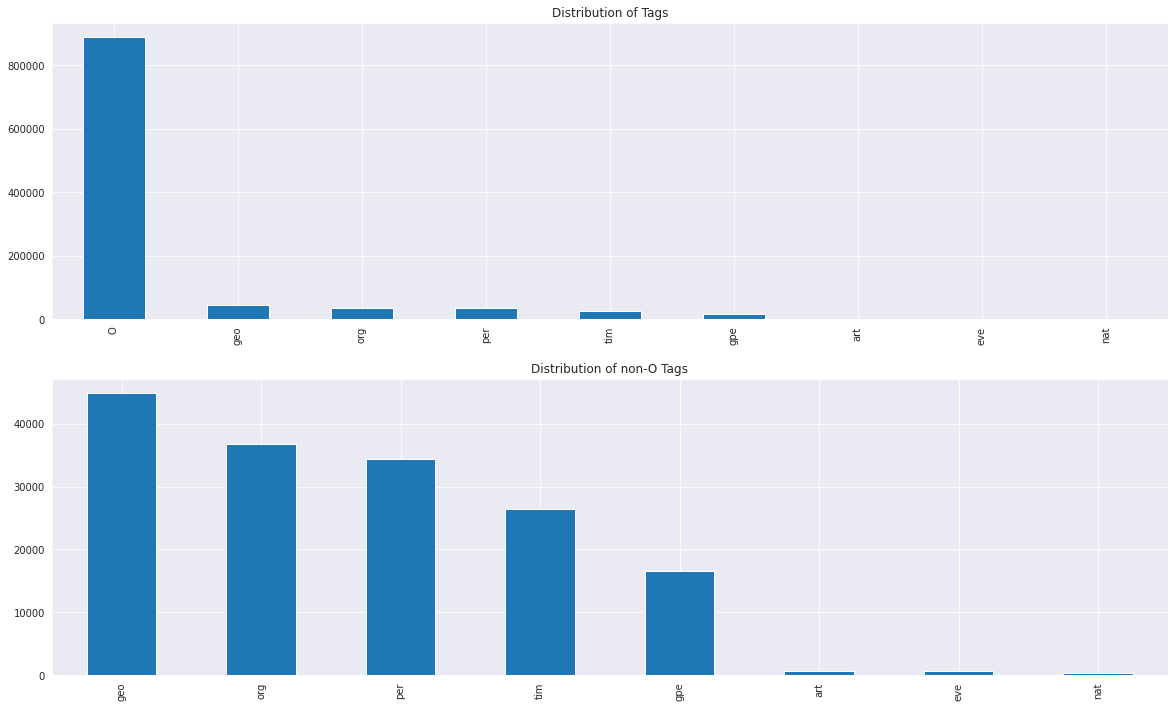

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

# Preprocessing

In [5]:
words = pd.DataFrame(data.groupby('sentence_idx')['word'].apply(list))
tags = data.groupby('sentence_idx')['tag'].apply(list)
words['tag'] = tags
words['sentence'] = words['word'].apply(lambda x: ' '.join(x))
words.head()

,word,tag,sentence
sentence_idx,,,
1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, geo, O, O, O, O, O, geo, O,...",Thousands of demonstrators have marched throug...
2,"[Families, of, soldiers, killed, in, the, conf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Families of soldiers killed in the conflict jo...
3,"[They, marched, from, the, Houses, of, Parliam...","[O, O, O, O, O, O, O, O, O, O, O, geo, geo, O,...",They marched from the Houses of Parliament to ...
4,"[Police, put, the, number, of, marchers, at, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","Police put the number of marchers at 10,000 wh..."
5,"[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, geo, O, O, o...",The protest comes on the eve of the annual con...


In [6]:
spacy_data = []
for idx, row in words.iterrows():
    tokens = row['word']
    tags = row['tag']
    entities = [
        (len(' '.join(tokens[:i])) + 1, len(' '.join(tokens[:i])) + len(tokens[i]) + 1, tags[i]) 
        if i != 0 else
        (len(' '.join(tokens[:i])), len(' '.join(tokens[:i])) + len(tokens[i]), tags[i])
        for i in range(len(tags)) if tags[i] != 'O'
    ]
    data_tuple = (row['sentence'], {'entities': entities})
    spacy_data.append(data_tuple)
spacy_data[:5]    

[('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  {'entities': [(48, 54, 'geo'),
    (77, 81, 'geo'),
    (111, 118, 'gpe'),
    (194, 200, 'geo'),
    (223, 227, 'geo'),
    (257, 264, 'gpe')]}),
 ('Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . " Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
  {'entities': [(109, 113, 'per'), (274, 278, 'per')]}),
 ('They marched from the Houses of Parliament to a rally in Hyde Park . They marched from the Houses of Parliament to a rally in Hyde Park .',
  {'entities': [(57

# Modelling

In [7]:
%%capture
!pip uninstall spacy -y
!pip install spacy==2.3.1

In [8]:
import spacy
spacy.__version__

'2.3.1'

In [9]:
nlp = spacy.blank('en') 
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner, last=True)

for _, annotations in spacy_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  
    optimizer = nlp.begin_training()
    for itn in range(5):
        random.shuffle(spacy_data)
        losses = {}
        for text, annotations in tqdm(spacy_data):
            nlp.update([text], [annotations], drop=0.5, sgd=optimizer, losses=losses)
        print(losses)

/opt/conda/lib/python3.7/site-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs


  0%|          | 0/35177 [00:00<?, ?it/s]

{'ner': 96258.99445936801}


  0%|          | 0/35177 [00:00<?, ?it/s]

{'ner': 74699.34033583982}


  0%|          | 0/35177 [00:00<?, ?it/s]

{'ner': 73121.02851721166}


  0%|          | 0/35177 [00:00<?, ?it/s]

{'ner': 73450.97495394941}


  0%|          | 0/35177 [00:00<?, ?it/s]

{'ner': 73554.321797666}


In [10]:
for text, _ in spacy_data[:5]:
    doc = nlp(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])

Entities [('Indian', 'gpe'), ('West', 'geo'), ('Bengal', 'geo')]
Entities [('U.S.', 'geo')]
Entities []
Entities [('Japan', 'geo'), ('Kenichiro', 'per'), ('Sasae', 'per'), ('North', 'geo'), ('Korea', 'geo'), ('Japanese', 'gpe'), ('1970s', 'tim'), ('South', 'geo'), ('Korea', 'geo')]
Entities [('Mohammed', 'per'), ('Ali', 'per'), ('Jinnah', 'per'), ('Hindu', 'org'), ('Mr.', 'per'), ('Jinnah', 'per'), ('1947', 'tim')]


In [11]:
nlp.to_disk('model')